## 3f. Explainable Artificial Intelligence (XAI) - Shapley Additive Explanation (SHAP) using DeepSHAP for Keras Neural Network

### Load Data and the Saved Model

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt

# Load the data
df = pd.read_csv("../preprocessed/clean_survey.csv")

# Split to independent and dependent variables
X = df.drop(['q_031_adjusted', 'invol_score', 'q_031', 'involvement_level'] + [f'q_0{i}' for i in range(45, 55)], axis=1)
y = df["involvement_level"]

# Encode the class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and test sets
X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)

# Data Preprocessing
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store in dataframe for plotting
feature_names = X_train.columns.tolist()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(label_mapping)

2024-09-19 17:37:31.018270: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 17:37:31.248852: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 17:37:31.251346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 17:37:32.483456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


{0: 'High', 1: 'Low', 2: 'Medium'}


In [2]:
print("Shape of X_train_scaled:", X_train_scaled.shape)  # Should be (num_samples, num_features)
print("Shape of y_encoded_train:", y_encoded_train.shape)  # Should be (num_samples,)

Shape of X_train_scaled: (656, 91)
Shape of y_encoded_train: (656,)


In [3]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('../models/neural_1_tensor.h5')

In [4]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               17664     
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                6176      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1

In [5]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, hamming_loss
import numpy as np

# Evaluate the model
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions
# y_test_labels = np.argmax(y_encoded_test, axis=1)  # Convert one-hot to labels for evaluation

# Calculate various metrics
print("Accuracy:", accuracy_score(y_encoded_test, y_pred))
print("Hamming Loss:", hamming_loss(y_encoded_test, y_pred))
print("F1 Score (Micro):", f1_score(y_encoded_test, y_pred, average='micro'))
print("F1 Score (Macro):", f1_score(y_encoded_test, y_pred, average='macro'))
print("F1 Score (Weighted):", f1_score(y_encoded_test, y_pred, average='weighted'))
# ROC-AUC for multi-class
roc_auc = roc_auc_score(y_encoded_test, y_pred_prob, average='macro', multi_class='ovr')
print("ROC-AUC (Macro):", roc_auc)

7/7 [==============================] - 0s 1ms/step
Accuracy: 0.6666666666666666
Hamming Loss: 0.3333333333333333
F1 Score (Micro): 0.6666666666666666
F1 Score (Macro): 0.5990280327418168
F1 Score (Weighted): 0.6684647477821015
ROC-AUC (Macro): 0.8151189053000794


### 3.1 Compute Shapley Values (Using Testing Set)

In [6]:
import shap
import pickle
shap.initjs()
# Make sure the input data is in the correct format (e.g., a NumPy array)

shap_explainer = shap.DeepExplainer(model, X_train_scaled)
with open('../shaps/shap_values_deep.pkl', 'rb') as file:
    shap_values = pickle.load(file)
# shap_values_scaled = shap_explainer.shap_values(X_test_scaled)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [7]:
shap_values

[array([[ 0.0039332 , -0.00428478, -0.00087808, ...,  0.00012781,
         -0.00720265, -0.02535841],
        [-0.00070439, -0.00088882,  0.00341947, ...,  0.00031423,
          0.00267986,  0.00094774],
        [-0.00045402,  0.00438127,  0.00119201, ..., -0.0001406 ,
         -0.00230818,  0.00063018],
        ...,
        [ 0.07535728,  0.05676716,  0.11894098, ...,  0.0041971 ,
         -0.01887751,  0.01287793],
        [ 0.00148455,  0.00217061,  0.00456945, ..., -0.00012313,
          0.00014558,  0.00233525],
        [-0.0028306 , -0.01799221,  0.01437432, ...,  0.00861776,
          0.03484212,  0.03294131]]),
 array([[-4.32226571e-02,  1.52734444e-02, -5.57628900e-03, ...,
          1.41075281e-02,  1.97060476e-02, -9.09059215e-02],
        [-6.70408027e-03, -7.56868574e-04, -7.96514308e-03, ...,
          7.34458901e-04,  2.04332396e-02, -1.88699921e-03],
        [-4.09864534e-03,  1.39355641e-02, -1.02607460e-03, ...,
          6.74824468e-04, -3.46356673e-03, -2.76405566e-

In [8]:
# Retrieve feature names after dropping columns
feature_names = X.columns.tolist()
expected_value = np.array(shap_explainer.expected_value)

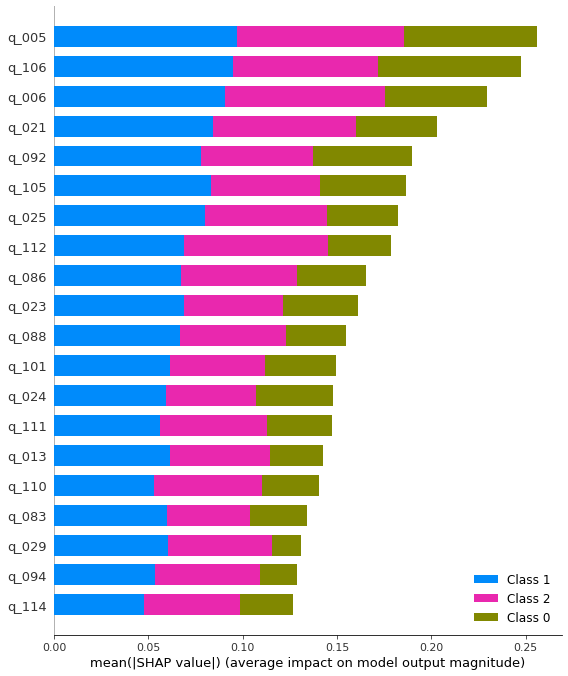

In [9]:
shap.initjs
shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist())

In [10]:
# Aggregate SHAP values across all classes, then compute the mean absolute value for each feature
aggregated_shap = np.sum([np.abs(values) for values in shap_values], axis=0)
mean_abs_shap_values = np.mean(aggregated_shap, axis=0)

mean_abs_shap_values



array([0.05555628, 0.05838337, 0.06043525, 0.04359921, 0.25622367,
       0.22940503, 0.07972027, 0.07244328, 0.08097241, 0.12176233,
       0.07608213, 0.1424201 , 0.07641048, 0.11976899, 0.05773789,
       0.03916256, 0.11048776, 0.06642323, 0.20320743, 0.12444673,
       0.16111337, 0.14797424, 0.18208425, 0.08445027, 0.13075853,
       0.10093769, 0.08940605, 0.0505894 , 0.09340323, 0.09090635,
       0.06925839, 0.09586712, 0.05552298, 0.0664016 , 0.04789889,
       0.11581275, 0.03600968, 0.11795438, 0.09001862, 0.06648671,
       0.13401153, 0.11971961, 0.12122952, 0.16522098, 0.12517568,
       0.15455029, 0.08949728, 0.05645223, 0.0707493 , 0.18948143,
       0.06027875, 0.12886902, 0.0620111 , 0.10457668, 0.14959395,
       0.10310978, 0.06036926, 0.07265488, 0.18638094, 0.24733441,
       0.11677988, 0.08802532, 0.07954968, 0.140229  , 0.14753759,
       0.17863965, 0.08832193, 0.12666366, 0.05062968, 0.10090837,
       0.10369346, 0.05808755, 0.06095805, 0.05839047, 0.09640

In [11]:
# Create a DataFrame for easier manipulation and visualization
df_feature_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'MeanAbsSHAP': mean_abs_shap_values
}).sort_values(by='MeanAbsSHAP', ascending=False)

# Calculate cumulative sum of mean absolute SHAP values
df_feature_importances['CumulativeSum'] = df_feature_importances['MeanAbsSHAP'].cumsum()
df_feature_importances['CumulativePercentage'] = df_feature_importances['CumulativeSum'] / df_feature_importances['MeanAbsSHAP'].sum() * 100
df_feature_importances['RateOfChange'] = df_feature_importances['CumulativeSum'].pct_change() * 100
with open('../shaps/df_feature_contri_deep.pkl', 'wb') as f:
    pickle.dump(df_feature_importances, f)

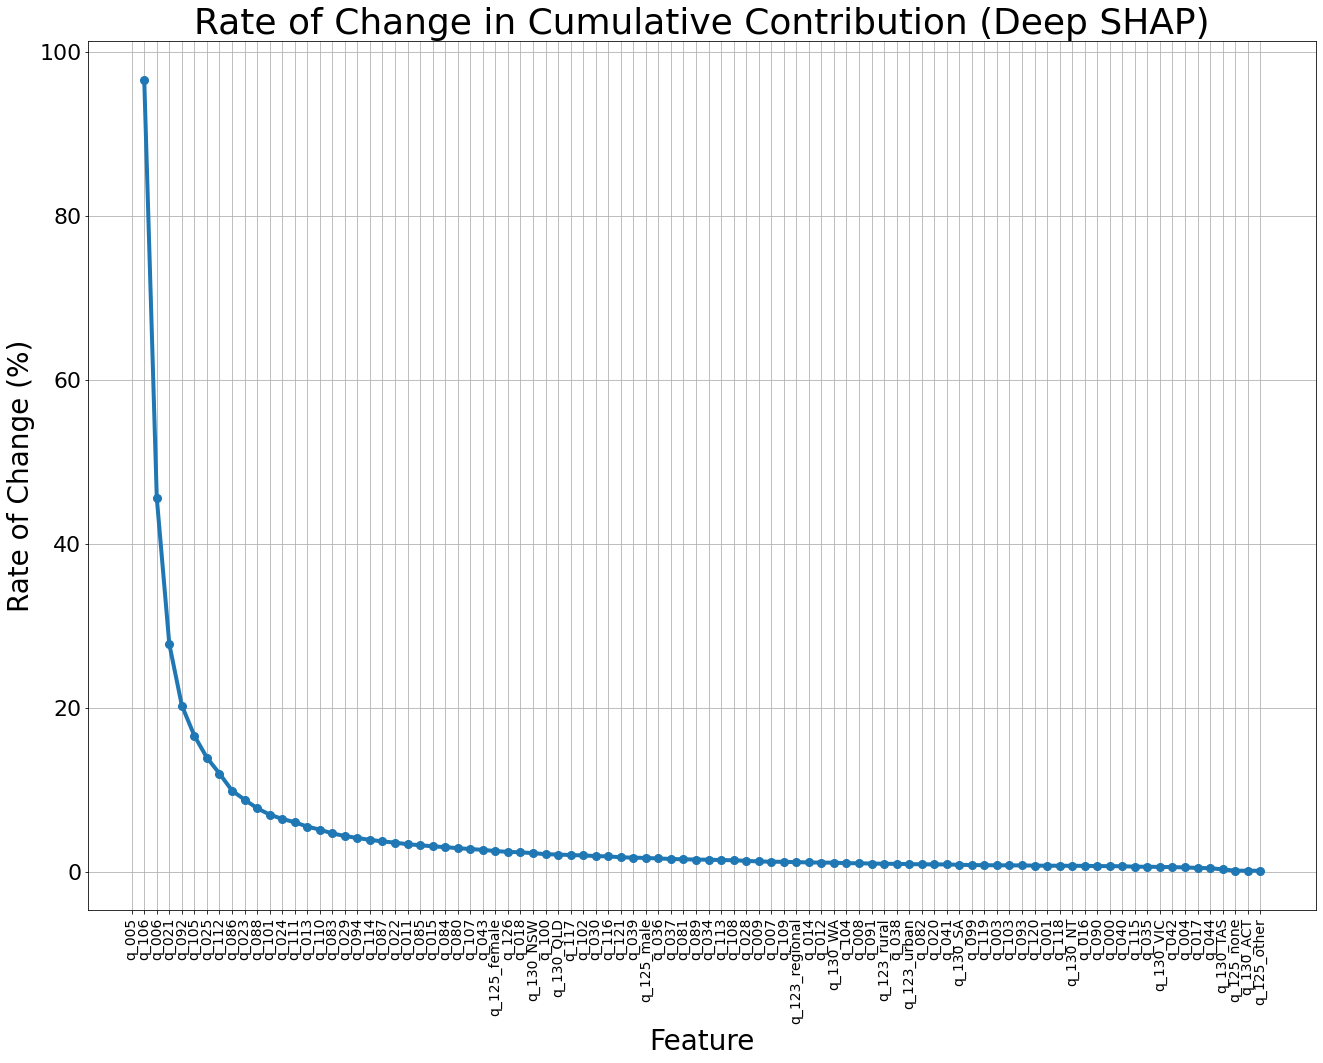

In [12]:
plt.figure(figsize=(22, 16))
plt.plot(df_feature_importances['Feature'], df_feature_importances['RateOfChange'], marker='o', markersize=8, lw=4)
plt.title('Rate of Change in Cumulative Contribution (Deep SHAP)', fontsize=36)
plt.xlabel('Feature', fontsize=28)
plt.ylabel('Rate of Change (%)', fontsize=28)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=22)
plt.grid(True)
plt.show()

In [13]:
def stain_labels(X, y, feature_names, target_label):
    y_stained = y.copy()
    stain_indices = np.zeros(len(y), dtype=bool)
    
    for feature_name in feature_names:
        feature_values = X[feature_name].values
        stain_indices |= feature_values > feature_values.mean()  # Example complex rule: OR across multiple features
    
    y_stained[stain_indices] = target_label
    return y_stained, stain_indices

# Define a function to calculate recall of important features
def calculate_recall(shap_values, stain_indices, feature_index):
    """
    Calculate recall of the stained feature in SHAP values.
    
    Parameters:
    shap_values : list of ndarray : SHAP values for each class
    stain_indices : ndarray : Indices of stained examples
    feature_index : int : Index of the stained feature
    
    Returns:
    float : Recall score
    """
    important_features = np.argmax(np.abs(shap_values), axis=-1)
    stained_important = important_features[stain_indices] == feature_index
    recall = np.mean(stained_important)
    return recall

from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense

# Verify that the model's behavior aligns with the staining function
def verify_stained_model(model, X_test_scaled, original_labels, staining_function, feature_index):
    predictions = model.predict(X_test_scaled)
    predicted_classes = np.argmax(predictions, axis=1)
    
    feature_values = X_test_scaled[:, feature_index]
    expected_stain_indices = feature_values > feature_values.mean()
    expected_labels = staining_function[expected_stain_indices]
    
    # Compare the model's predictions with the expected staining function's labels
    agreement_stained = np.mean(predicted_classes[expected_stain_indices] == expected_labels)
    agreement_original = np.mean(predicted_classes == original_labels)
    
    print(f"Agreement between model predictions and staining function: {agreement_stained * 100:.2f}%")
    print(f"Agreement between model predictions and original labels: {agreement_original * 100:.2f}%")
    return agreement_stained, agreement_original


### Staining Model Validation

In [14]:
import shap
# List of features to iterate over
features_to_stain = df_feature_importances[
    (df_feature_importances['RateOfChange'].isna()) | 
    (df_feature_importances['RateOfChange'] >= 3)
]['Feature'].tolist()
target_stain_label = 0  # Example target label (e.g., 'High')

# Initialize list to store recall scores
all_recalls = []

for feature_to_stain in features_to_stain:
    print(f"Staining and evaluating feature: {feature_to_stain}")
    
    # Convert feature name to index
    feature_index = feature_names.index(feature_to_stain)
    
    # Create stained labels for training set
    y_stained_train, stain_indices_train = stain_labels(X_train_scaled_df, y_encoded_train, [feature_to_stain], target_stain_label)
    
    # Create and train the stained model
    model_stained = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    model_stained.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_stained.fit(X_train_scaled, y_stained_train, epochs=10, batch_size=32, validation_split=0.2, verbose=False)
    
    # Verify the model
    staining_function = np.full_like(y_encoded_test, target_stain_label)
    agreement_stained, agreement_original = verify_stained_model(model_stained, X_test_scaled, y_encoded_test, staining_function, feature_index)
    
    # Only proceed if the model passes the validation step for stained labels
    if agreement_stained >= 0.9 and agreement_original < 0.6:  # Ensures model isn't trivially learning the stain
        # Identify stained indices in the test set
        _, stain_indices_test = stain_labels(X_test_scaled_df, y_encoded_test, [feature_to_stain], target_stain_label)
        
        # Fit the SHAP DeepExplainer
        shap_explainer_stained = shap.DeepExplainer(model_stained, X_train_scaled)
        shap_values_stained = shap_explainer_stained.shap_values(X_test_scaled)
        
        # Get the index of the stained feature
        feature_index = feature_names.index(feature_to_stain)
        
        # Calculate recall for each class
        recalls = [calculate_recall(shap_values_class, stain_indices_test, feature_index) for shap_values_class in shap_values_stained]
        
        # Average recall across classes
        average_recall = np.mean(recalls)
        
        # Store the average recall
        all_recalls.append(average_recall)
    else:
        print(f"Model for feature {feature_to_stain} did not pass the validation step.")

# Average recall across all features
if all_recalls:
    final_average_recall = np.mean(all_recalls)
    print("Final Average Recall of Stained Features:", final_average_recall)
else:
    print("No models passed the validation step.")

Staining and evaluating feature: q_005
7/7 [==============================] - 0s 1ms/step
Agreement between model predictions and staining function: 93.75%
Agreement between model predictions and original labels: 47.49%


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Staining and evaluating feature: q_106
7/7 [==============================] - 0s 1ms/step
Agreement between model predictions and staining function: 90.28%
Agreement between model predictions and original labels: 44.75%
Staining and evaluating feature: q_006
7/7 [==============================] - 0s 1ms/step
Agreement between model predictions and staining function: 93.42%
Agreement between model predictions and original labels: 51.14%
Staining and evaluating feature: q_021
7/7 [==============================] - 0s 2ms/step
Agreement between model predictions and staining function: 97.00%
Agreement between model predictions and original labels: 43.38%
Staining and evaluating feature: q_092
7/7 [==============================] - 0s 2ms/step
Agreement between model predictions and staining function: 91.67%
Agreement between model predictions and original labels: 33.79%
Staining and evaluating feature: q_105
7/7 [==============================] - 0s 2ms/step
Agreement between model predic

In [15]:
"""important_features = df_feature_importances[(df_feature_importances['RateOfChange'].isna()) | (df_feature_importances['RateOfChange'] >= 3)]['Feature'].tolist()
# Get the column indices for the feature names
column_indices = [X.columns.get_loc(col) for col in important_features]

# Convert the list of column indices to a NumPy array
top_feature_index = np.array(column_indices)
#threshold = np.percentile(X_train_scaled[:, top_feature_index], 75)
new_label = 0  # New label to High Class since its minority

stained_X_train, stained_y_train = stain_data(X_train_scaled, y_encoded_train, top_feature_index, new_label)
model.fit(stained_X_train, stained_y_train, epochs=10, batch_size=32, validation_split=0.2)

# Obtain SHAP values for the stained model
shap_explainer_stained = shap.DeepExplainer(model, stained_X_train)
shap_values_stained = shap_explainer_stained.shap_values(X_test_scaled)

# Evaluate faithfulness
faithfulness_score = evaluate_faithfulness(shap_values_stained[new_label], X_test_scaled, top_feature_index, new_label)"""


"important_features = df_feature_importances[(df_feature_importances['RateOfChange'].isna()) | (df_feature_importances['RateOfChange'] >= 3)]['Feature'].tolist()\n# Get the column indices for the feature names\ncolumn_indices = [X.columns.get_loc(col) for col in important_features]\n\n# Convert the list of column indices to a NumPy array\ntop_feature_index = np.array(column_indices)\n#threshold = np.percentile(X_train_scaled[:, top_feature_index], 75)\nnew_label = 0  # New label to High Class since its minority\n\nstained_X_train, stained_y_train = stain_data(X_train_scaled, y_encoded_train, top_feature_index, new_label)\nmodel.fit(stained_X_train, stained_y_train, epochs=10, batch_size=32, validation_split=0.2)\n\n# Obtain SHAP values for the stained model\nshap_explainer_stained = shap.DeepExplainer(model, stained_X_train)\nshap_values_stained = shap_explainer_stained.shap_values(X_test_scaled)\n\n# Evaluate faithfulness\nfaithfulness_score = evaluate_faithfulness(shap_values_stained

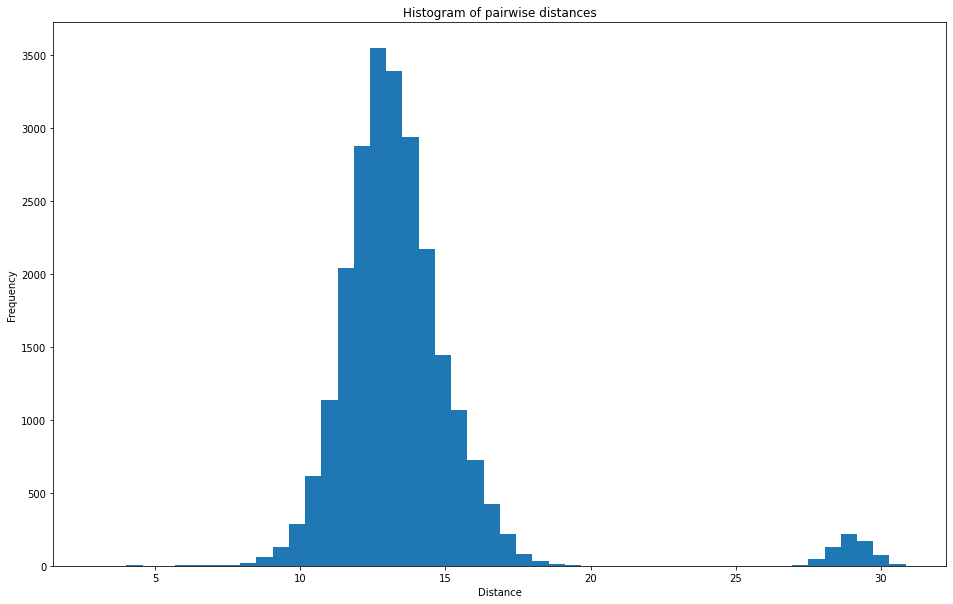

In [16]:
from scipy.spatial.distance import pdist, squareform

# Calculate pairwise distances
pairwise_distances = pdist(X_test_scaled, metric='euclidean')
distance_matrix = squareform(pairwise_distances)

# Plot histogram of distances
plt.figure(figsize=(16, 10))
plt.hist(pairwise_distances, bins=50)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of pairwise distances')
plt.show()

In [17]:
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr
import random

def max_sensitivity(X_test, shap_values, r=0.1):
    sensitivities = []
    for i, x in enumerate(X_test):
        # Find all points within a radius r of the current test point x
        neighborhood = X_test[np.linalg.norm(X_test - x, axis=1) < r]
        if len(neighborhood) > 1:
            # Flatten SHAP values for the test point and its neighbors
            shap_values_flat = np.concatenate([shap_values[class_idx][i] for class_idx in range(len(shap_values))])
            neighborhood_flat = [np.concatenate([shap_values[class_idx][j] for class_idx in range(len(shap_values))]) for j in range(len(neighborhood))]
            
            # Calculate pairwise distances between the test point's SHAP values and its neighbors' SHAP values
            distances = pairwise_distances([shap_values_flat], neighborhood_flat)
            max_sensitivity = np.max(distances)  # Find the maximum distance
            sensitivities.append(max_sensitivity)
        else:
            sensitivities.append(np.nan)  # Append NaN if the neighborhood is too small
    mean_max_sensitivity = np.nanmean(sensitivities)  # Compute the mean, ignoring NaNs
    return mean_max_sensitivity

def avg_sensitivity(X_test, shap_values, r=0.1):
    sensitivities = []
    for i, x in enumerate(X_test):
        # Find all points within a radius r of the current test point x
        neighborhood = X_test[np.linalg.norm(X_test - x, axis=1) < r]
        if len(neighborhood) > 1:
            # Flatten SHAP values for the test point and its neighbors
            shap_values_flat = np.concatenate([shap_values[class_idx][i] for class_idx in range(len(shap_values))])
            neighborhood_flat = [np.concatenate([shap_values[class_idx][j] for class_idx in range(len(shap_values))]) for j in range(len(neighborhood))]
            
            # Calculate pairwise distances between the test point's SHAP values and its neighbors' SHAP values
            distances = pairwise_distances([shap_values_flat], neighborhood_flat)
            avg_sensitivity = np.mean(distances)  # Find the average distance
            sensitivities.append(avg_sensitivity)
        else:
            sensitivities.append(np.nan)  # Append NaN if the neighborhood is too small
    mean_avg_sensitivity = np.nanmean(sensitivities)  # Compute the mean, ignoring NaNs
    return mean_avg_sensitivity

def faithfulness(X_train_scaled, X_test, shap_values, model, subset_sizes=[20, 50, 80]):
    random.seed(42)
    np.random.seed(42)
    faithfulness_scores = []
    baseline = np.mean(X_train_scaled, axis=0)
    for i, x in enumerate(X_test):
        shap_sums = []
        y_diffs = []
        for subset_size in subset_sizes:
            # Randomly select a subset of features
            indices = np.random.choice(len(x), subset_size, replace=False)
            x_baseline = np.copy(x)
            x_baseline[indices] = baseline[indices]
            y_diff = model.predict(np.array([x]))[0] - model.predict(np.array([x_baseline]))[0]
            shap_sum = np.sum([shap_values[class_idx][i][indices] for class_idx in range(len(shap_values))])
            shap_sums.append(shap_sum)
            y_diffs.append(y_diff.sum())
        
        if len(shap_sums) > 1 and len(y_diffs) > 1:
            if np.var(shap_sums) != 0 and np.var(y_diffs) != 0:  # Check for variance
                corr, _ = pearsonr(shap_sums, y_diffs)
                faithfulness_scores.append(corr)
            else:
                faithfulness_scores.append(np.nan)  # Append NaN if no variance in data
        else:
            faithfulness_scores.append(np.nan)
    
    mean_faithfulness = np.nanmean(faithfulness_scores)  # Compute the mean, ignoring NaNs
    return mean_faithfulness

def complexity(shap_values):
    complexities = []
    for i in range(len(shap_values[0])):  # Number of test samples
        for class_idx in range(len(shap_values)):  # Number of classes
            P_g = np.abs(shap_values[class_idx][i]) / np.sum(np.abs(shap_values[class_idx][i]))  # Normalize SHAP values
            complexity = -np.sum(P_g * np.log(P_g + 1e-9))  # Calculate entropy
            complexities.append(complexity)
    mean_complexity = np.mean(complexities)
    return mean_complexity

In [18]:
# Compute the metrics
mean_max_sensitivity = max_sensitivity(X_test_scaled, shap_values, r=15)
mean_avg_sensitivity = avg_sensitivity(X_test_scaled, shap_values, r=15)
mean_faithfulness = faithfulness(X_train_scaled, X_test_scaled, shap_values, model)
mean_complexity = complexity(shap_values)

# Print the results
print("Mean Max Sensitivity:", mean_max_sensitivity)
print("Mean Avg Sensitivity:", mean_avg_sensitivity)
print("Mean Faithfulness:", mean_faithfulness)
print("Mean Complexity:", mean_complexity)

1/1 [==============================] - 0s 106ms/step
Mean Max Sensitivity: 10.735560536214741
Mean Avg Sensitivity: 1.5492260706415546
Mean Faithfulness: 0.009884809381035909
Mean Complexity: 3.982697673390276


In [19]:
# Features of interest
features_of_interest = {'q_005', 'q_021', 'q_024', 'q_025', 'q_105', 'q_106', 'q_112', 'q_114'}

# Filter the DataFrame
filtered_df = df_feature_importances[df_feature_importances['Feature'].isin(features_of_interest)]

# Calculate the cumulative sum of 'CumulativeSum' for the filtered features
cumulative_sum_of_interest = filtered_df['CumulativeSum'].sum()

print("Cumulative sum of selected features:", cumulative_sum_of_interest)

Cumulative sum of selected features: 12.027767821451658
